### Problem Statement:
To create a model that reasonably accurately forecasts team scores (the final scores for Team A & Team B) for NBA basketball games

### Potential methods and models:
The plan of attack will be Linear Regression

### Available data:
I have 2.5 years of individual game data (the current season is halfway complete).  Additionally, current team stats are readily available at NBA.com and are easily sliceable.  I opted not to go back further in time beyond two years of data as I believe that the style of the game (a higher emphasis on the three point shot and a faster pace of play) has changed enough since then so as to render data older than two years as to be not representative of the way that the game is currently played.  I will train on the last two years and test on the current (half) season.

### Questions, assumptions, risks, and caveats:
This process will yield a baseline result -- and then on top of that adjustments would be layered on.  I suspect this is how the professional oddsmakers also create their numbers.  Examples of adjustments could include injuries to significant players, teams playing on the back end of a back-to-back (where fatigue would be a factor), early game start times, a significant public favorite that will skew the lines away from the model output, etc.  Given the complexity of the adjustment process I will aim to only focus on "plain vanilla" games (of which there would still be plenty) which have no peculiarities to the matchup that would require significant adjustments.

### Benchmarks:
The initial focus of the model should just aim to come very close (generally within a few points) of the published betting lines -- which are known to be highly efficient.  Once this has been accomplished, further iterations of the project could aim to "beat" the accuracy of the betting lines when compared to the actual game scores.  This would likely require more advanced statistical techniques than solely linear regression.

### Goals and success criteria:
Forecasts that are generally within a few points of the published betting lines for Team A and Team B for "plain vanilla" games (games not requiring significant adjustments)

In [79]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats

from sklearn import feature_selection, linear_model

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

Read in the training dataset (the 2014-15 and 2015-16 seasons).  Later the test dataset (the current season 2016-17, halfway through) will also be read in.

In [4]:
df = pd.read_excel('2014-2017_combined_NBA_Box_Score_Team_Stats.xlsx','2014-16_combined_regular_season')

In [5]:
df.shape

(4920, 56)

In [6]:
df

,DATASET,DATE,TEAMS,VENUE,1Q,...,MONEYLINE,HALFTIME,BOX SCORE,ODDS,VEGAS_PREDICTED_PTS
0,2015-2016 Regular Season,10/27/2015,Detroit,Road,25,...,255,98,NaN,NaN,94.75
1,2015-2016 Regular Season,10/27/2015,Atlanta,Home,25,...,-320,-7 -15,Boxscore,Odds,101.75
2,2015-2016 Regular Season,10/27/2015,Cleveland,Road,17,...,160,97o15,NaN,NaN,97.25
3,2015-2016 Regular Season,10/27/2015,Chicago,Home,26,...,-180,PK,Boxscore,Odds,101.25
4,2015-2016 Regular Season,10/27/2015,New Orleans,Road,35,...,510,108,NaN,NaN,102.25
5,2015-2016 Regular Season,10/27/2015,Golden State,Home,39,...,-710,-3,Boxscore,Odds,112.75
6,2015-2016 Regular Season,10/28/2015,Washington,Road,31,...,-180,-2.5,NaN,NaN,103.25
7,2015-2016 Regular Season,10/28/2015,Orlando,Home,29,...,160,100.5,Boxscore,Odds,99.25
8,2015-2016 Regular Season,10/28/2015,Philadelphia,Road,26,...,800,98.5,NaN,NaN,92.75
9,2015-2016 Regular Season,10/28/2015,Boston,Home,21,...,-1300,-4.5,Boxscore,Odds,105.25


In [51]:
for column in df.columns:
    print column

DATASET
DATE
TEAMS
VENUE
1Q
2Q
3Q
4Q
OT1
OT2
OT3
OT4
F
MIN
FG
FGA
3P
3PA
FT
FTA
OR
DR
TOT
A
PF
ST
TO
TO TO
BL
PTS
POSS
eFG_pct
TOV_pct
ORB_pct
FT_divby_FGA
PACE
OEFF
DEFF
REST DAYS
STARTING SF
STARTING PF
STARTING C
STARTING SG
STARTING PG
MAIN REF
CREW
OPENING ODDS
OPENING SPREAD
OPENING TOTAL
MOVEMENTS
CLOSING ODDS
MONEYLINE
HALFTIME
BOX SCORE
ODDS
VEGAS_PREDICTED_PTS


### Data Dictionary
A data dictionary can be found here: http://www.basketball-reference.com/about/glossary.html
This dictionary does not completely line up with the columns above, but the columns above are also named in a standard, intuitive manner so if there is any question, a simple Google search should resolve any uncertainties.

As a start for the drivers of game results, this research: http://www.basketball-reference.com/about/factors.html indicates that eFG% (shooting), TOV% (turnovers), ORB% (rebounding), FT/FGA (free throws) are the "four factors of NBA success".  I also believe there is one more important factor -- Pace.  Pace should not drive success (the pace for any game is the same for both teams) -- but would drive total scores (slow paced games = lower scores for both teams and vice versa).  My dependent variable will be (of course) PTS.

### Histograms
Now, let's plot some histograms of the variables that we're likely most interested in: PTS, VEGAS_PREDICTED_PTS, eFG_pct, TOV_pct, ORB_pct, FT_divby_FGA, PACE.  Note: VEGAS_PREDICTED_PTS (the implied team points derived from the betting lines) is a derived field from the Vegas Game Spread and Vegas Game Total

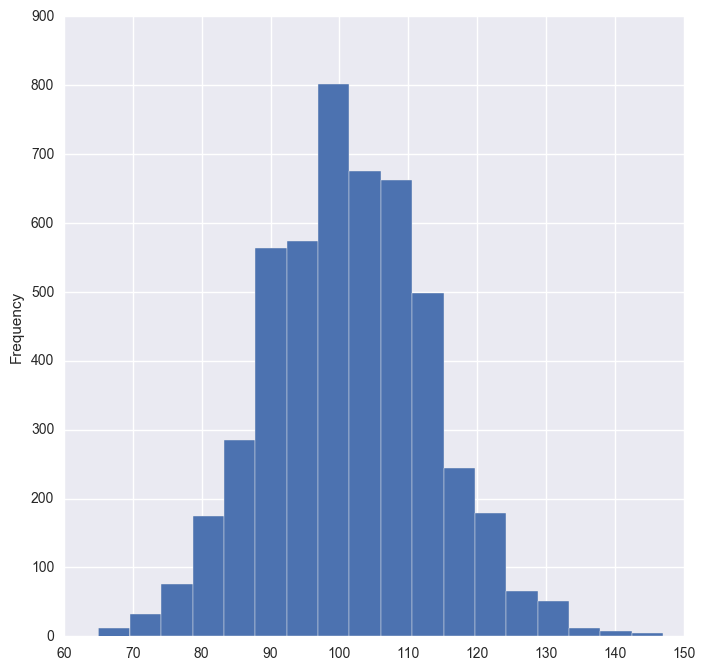

In [7]:
df.PTS.plot( kind = 'hist', bins=18, figsize = (8, 8))

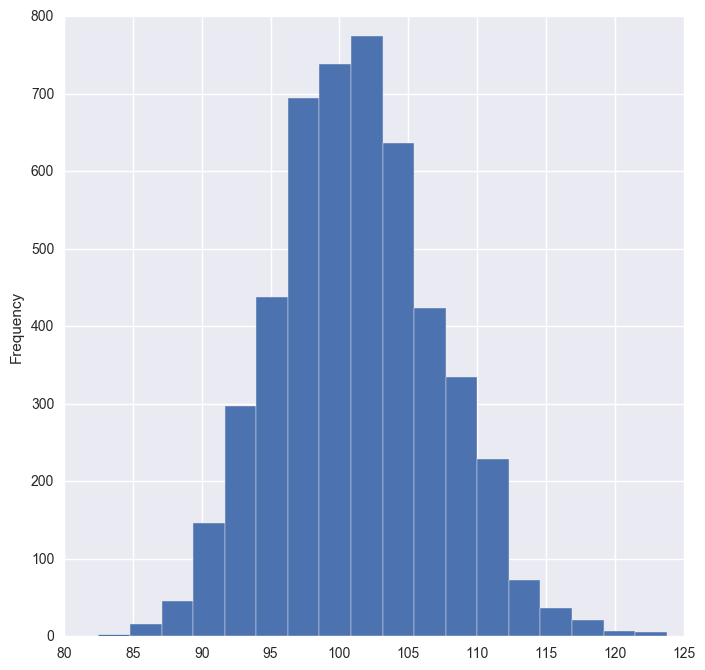

In [8]:
df.VEGAS_PREDICTED_PTS.plot(kind = 'hist', bins=18, figsize = (8, 8))

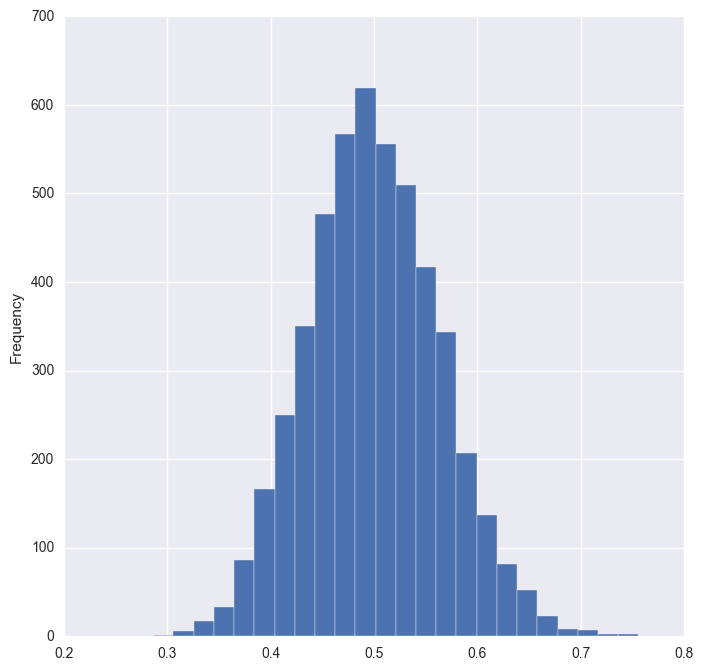

In [9]:
df.eFG_pct.plot(kind = 'hist', bins=24, figsize = (8, 8))

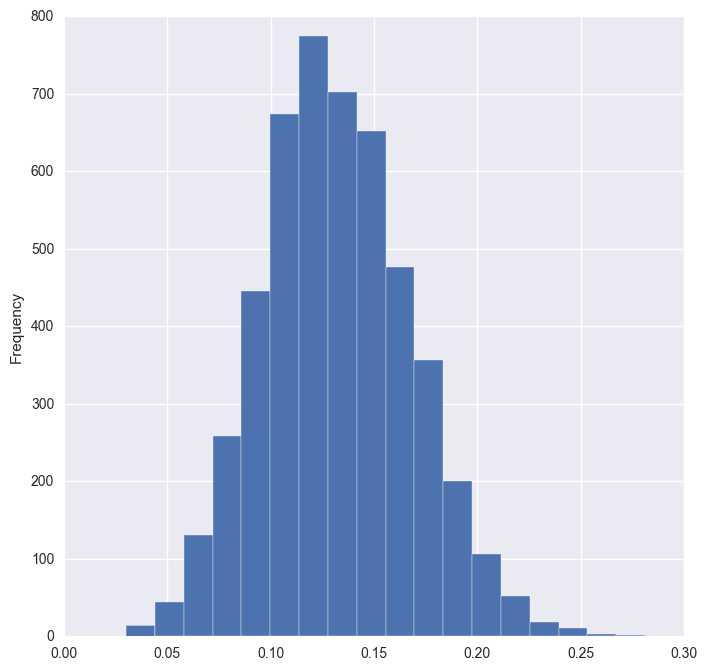

In [10]:
df.TOV_pct.plot(kind = 'hist', bins=18, figsize = (8, 8))

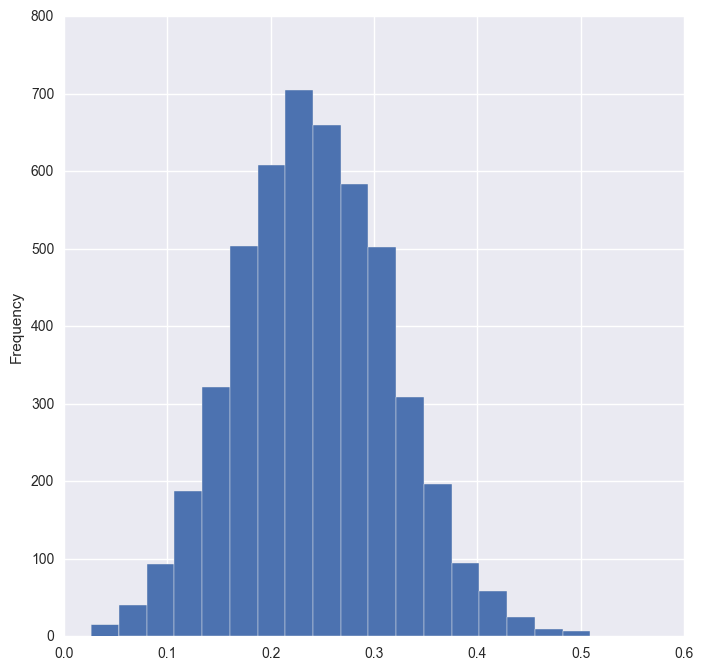

In [11]:
df.ORB_pct.plot(kind = 'hist', bins=18, figsize = (8, 8))

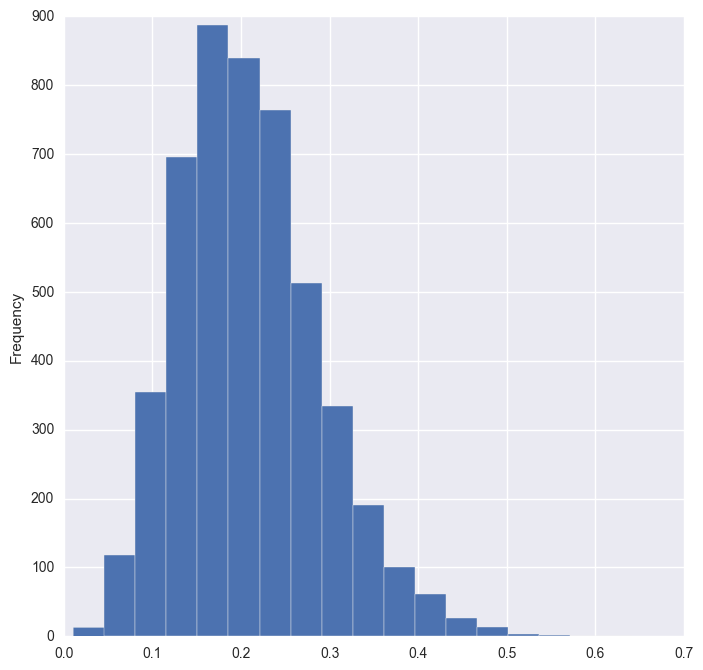

In [12]:
df.FT_divby_FGA.plot(kind = 'hist', bins=18, figsize = (8, 8))

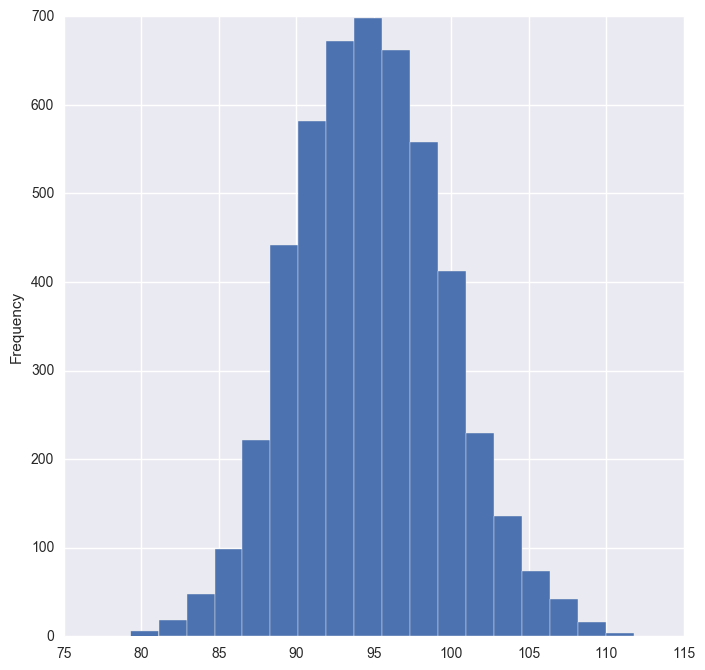

In [13]:
df.PACE.plot(kind = 'hist', bins=18, figsize = (8, 8))

### Commentary
In the above I imported data for each NBA regular season game over the past two years.  There are thirty teams and each team plays 82 games -- for a total of 2,460 games each year.  I believe that this should be a large enough dataset to draw meaningful conclusions.  I opted not to use data prior to the 2014-15 season as I believe that the style of the game has changed beginning in earnest with the 2014-15 season (more emphasis on the 3-pt shot and faster paces) so it would not be representative data of the current style played.

Each of the variables that I'm interested in as potential independent varialbes look to be approximately normally distributed

First, though, I would like to get a feel for how accurately Vegas has been at predicting the total points scored for Team A and Team B in each game:

In [14]:
df[ ['PTS', 'VEGAS_PREDICTED_PTS'] ].corr()

,PTS,VEGAS_PREDICTED_PTS
PTS,1.000000,0.459782
VEGAS_PREDICTED_PTS,0.459782,1.000000


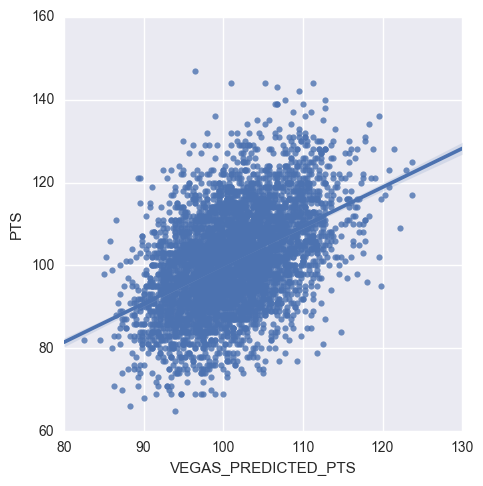

In [15]:
sns.lmplot(x = 'VEGAS_PREDICTED_PTS', y = 'PTS', data = df)

In [16]:
model = smf.ols(formula = 'PTS ~ VEGAS_PREDICTED_PTS', data = df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PTS   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1318.
Date:                Sat, 18 Feb 2017   Prob (F-statistic):          5.81e-256
Time:                        15:19:54   Log-Likelihood:                -18549.
No. Observations:                4920   AIC:                         3.710e+04
Df Residuals:                    4918   BIC:                         3.711e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               6.7239      2.610      2.576      0.010         1.607    11.841
VEGAS_PREDICTED_PTS     0.9345      0.026     36.309      0.000         0.884     0.985
==============================================================================
Omnibus:                       28.607   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.699
Skew:                           0.153   Prob(JB):                     2.16e-07
Kurtosis:                       3.238   Cond. No.                     1.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Commentary
It seems that Vegas has done a passable job at predicting the actual points scored by each team (both the Intercept and VEGAS_PREDICTED_PTS are signficant)... however the R-squared is only 0.211 (r = 0.459782 above)... and the scatterplot suggests that a superior model could potentially improve on the VEGAS_PREDICTED_PTS -- and thus actually "beat the market" so to speak.  Of course within sports there is also an inherent amount of randomness (variance) -- so it may also just not be reasonably possible to come up with a much tighter forecast. 

Let's take a look at correlations among the variables that we are potentially most interested in -- and a few more: A (assists), BL (blocks).

In [33]:
df[[ 'eFG_pct', 'TOV_pct', 'ORB_pct', 'FT_divby_FGA', 'PACE', 'PTS', 'A', 'BL'] ].corr()

,eFG_pct,TOV_pct,ORB_pct,FT_divby_FGA,PACE,PTS,A,BL
eFG_pct,1.000000,0.094140,-0.095952,0.016553,0.045386,0.736008,0.578155,0.033960
TOV_pct,0.094140,1.000000,0.054908,0.092651,0.184302,-0.210038,-0.064541,0.013157
ORB_pct,-0.095952,0.054908,1.000000,0.015808,-0.168133,0.145711,-0.017776,0.005712
FT_divby_FGA,0.016553,0.092651,0.015808,1.000000,0.116564,0.242830,-0.182963,0.001010
PACE,0.045386,0.184302,-0.168133,0.116564,1.000000,0.341400,0.196542,0.052378
PTS,0.736008,-0.210038,0.145711,0.242830,0.341400,1.000000,0.557566,0.051654
A,0.578155,-0.064541,-0.017776,-0.182963,0.196542,0.557566,1.000000,0.089273
BL,0.033960,0.013157,0.005712,0.001010,0.052378,0.051654,0.089273,1.000000


###  Commentary
Interestingly only eFG% seems to be positively correlated with PTS (and the other variables seem to be relatively independent of each other)

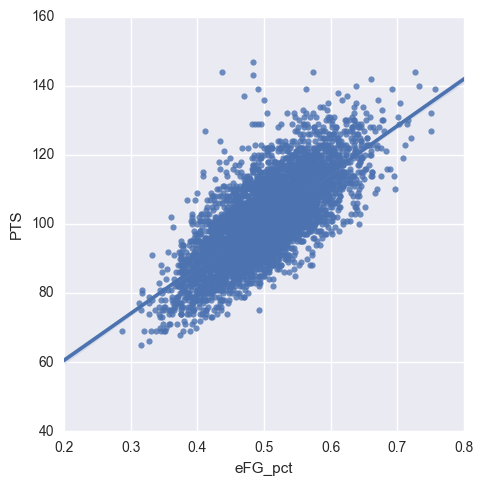

In [34]:
sns.lmplot(x = 'eFG_pct', y = 'PTS', data = df)

In [35]:
model = smf.ols(formula = 'PTS ~ eFG_pct + TOV_pct + ORB_pct + FT_divby_FGA + PACE', data = df[df['DATASET']=='2014-2015 Regular Season']).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PTS   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     3841.
Date:                Sat, 18 Feb 2017   Prob (F-statistic):               0.00
Time:                        15:30:38   Log-Likelihood:                -6873.9
No. Observations:                2460   AIC:                         1.376e+04
Df Residuals:                    2454   BIC:                         1.379e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      -68.0986      1.839    -37.031      0.000       -71.705   -64.493
eFG_pct        142.0063      1.254    113.204      0.000       139.546   144.466
TOV_pct       -131.0724      2.268    -57.785      0.000      -135.520  -126.624
ORB_pct         48.6863      1.101     44.229      0.000        46.528    50.845
FT_divby_FGA    32.2903      1.021     31.616      0.000        30.288    34.293
PACE             1.0231      0.018     55.958      0.000         0.987     1.059
==============================================================================
Omnibus:                     1771.504   Durbin-Watson:                   1.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32010.426
Skew:                           3.248   Prob(JB):                         0.00
Kurtosis:                      19.434   Cond. No.                     2.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
model = smf.ols(formula = 'PTS ~ eFG_pct + TOV_pct + ORB_pct + FT_divby_FGA + PACE', data = df[df['DATASET']=='2015-2016 Regular Season']).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PTS   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     4264.
Date:                Sat, 18 Feb 2017   Prob (F-statistic):               0.00
Time:                        15:30:38   Log-Likelihood:                -6756.2
No. Observations:                2460   AIC:                         1.352e+04
Df Residuals:                    2454   BIC:                         1.356e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      -64.1764      1.679    -38.217      0.000       -67.469   -60.883
eFG_pct        146.0224      1.207    120.956      0.000       143.655   148.390
TOV_pct       -130.5962      2.239    -58.331      0.000      -134.986  -126.206
ORB_pct         48.7894      1.043     46.790      0.000        46.745    50.834
FT_divby_FGA    31.5611      0.969     32.584      0.000        29.662    33.460
PACE             0.9632      0.016     59.737      0.000         0.932     0.995
==============================================================================
Omnibus:                     1708.494   Durbin-Watson:                   1.404
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39832.916
Skew:                           2.973   Prob(JB):                         0.00
Kurtosis:                      21.795   Cond. No.                     2.85e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As an attempt to improve the qqplot (below) I transformed eFG_pct by taking the log: df['log_eFG_pct'] = np.log(df['eFG_pct']) and replaced this transformed variable in the below regression... but it didn't make much of a dent in transforming the qqplot (so I've left things back to the original state).

In [44]:
model = smf.ols(formula = 'PTS ~  eFG_pct + TOV_pct + ORB_pct + FT_divby_FGA + PACE', data = df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PTS   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     8183.
Date:                Sat, 18 Feb 2017   Prob (F-statistic):               0.00
Time:                        15:39:00   Log-Likelihood:                -13640.
No. Observations:                4920   AIC:                         2.729e+04
Df Residuals:                    4914   BIC:                         2.733e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      -66.3090      1.224    -54.175      0.000       -68.709   -63.909
eFG_pct        144.0685      0.870    165.512      0.000       142.362   145.775
TOV_pct       -130.9208      1.593    -82.201      0.000      -134.043  -127.798
ORB_pct         48.6495      0.758     64.206      0.000        47.164    50.135
FT_divby_FGA    31.9940      0.704     45.441      0.000        30.614    33.374
PACE             0.9946      0.012     83.411      0.000         0.971     1.018
==============================================================================
Omnibus:                     3448.223   Durbin-Watson:                   1.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69954.757
Skew:                           3.114   Prob(JB):                         0.00
Kurtosis:                      20.391   Cond. No.                     2.76e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Commentary
The above results are stable whether just looking at the 2014-15 season, the 2015-16 season, or the combined 2014-16 two seasons.  This confirms that the entire dataset will be representative -- and as such, we'll use the combined 2014-16 two seasons.  I also toyed with including A (assists) and BL (blocks) into the regression, but they either weren't significant (Blocks) or just didn't improve on the R-squared (Assists) likely because assists was already correlated with eFG_pct.

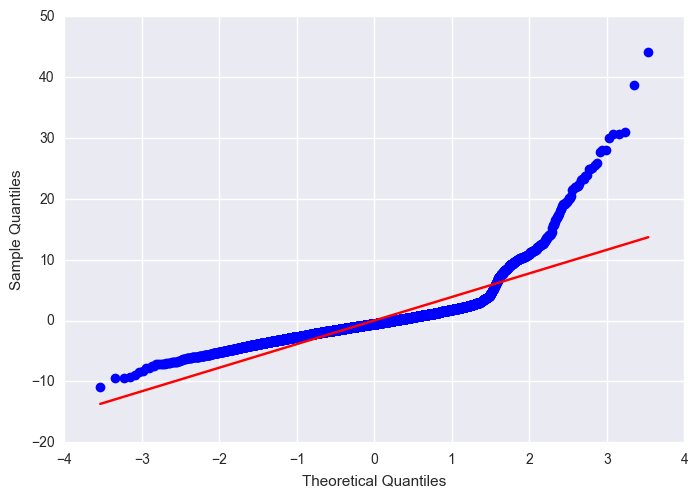

In [45]:
sm.qqplot(model.resid, line = 's')

pass

### Commentary
This qqpplot shows that the assumpion of our residuals being normally distibuted breaks down at the upper tail... potentially suggesting that a linear model may become unreliable with forecasts at the higher end of our dependent variable (PTS)... which may be a reflection of the way that the game continues to evolve to favor the three point shot -- and thus yielding some extreme outliers at the high end of PTS.

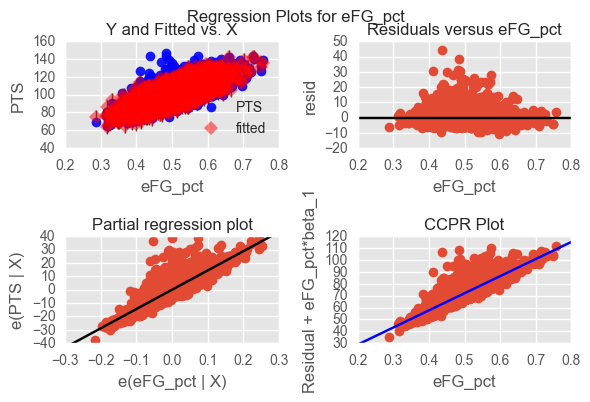

In [69]:
sm.graphics.plot_regress_exog(model, 'eFG_pct')

pass

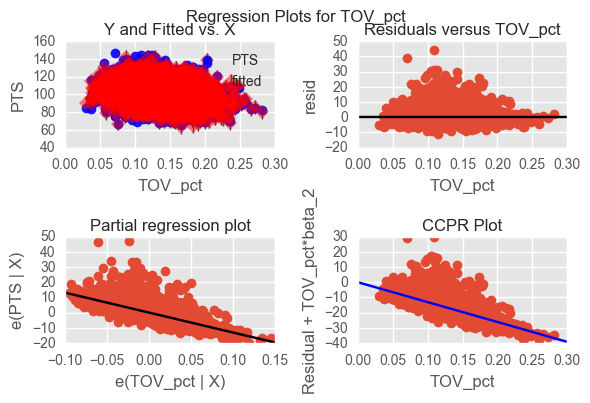

In [70]:
sm.graphics.plot_regress_exog(model, 'TOV_pct')

pass

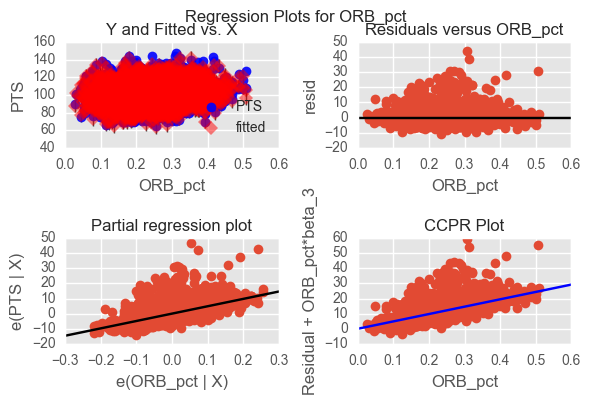

In [71]:
sm.graphics.plot_regress_exog(model, 'ORB_pct')

pass

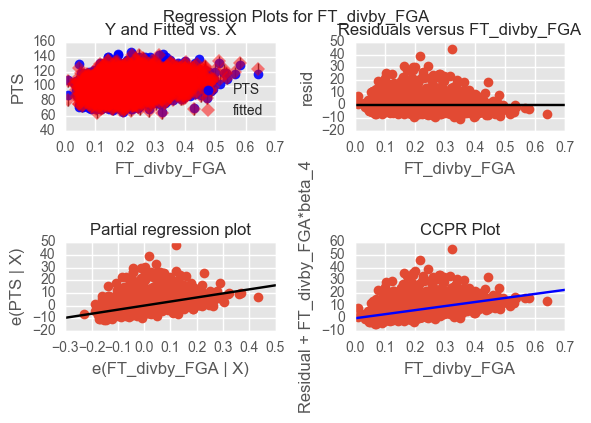

In [72]:
sm.graphics.plot_regress_exog(model, 'FT_divby_FGA')

pass

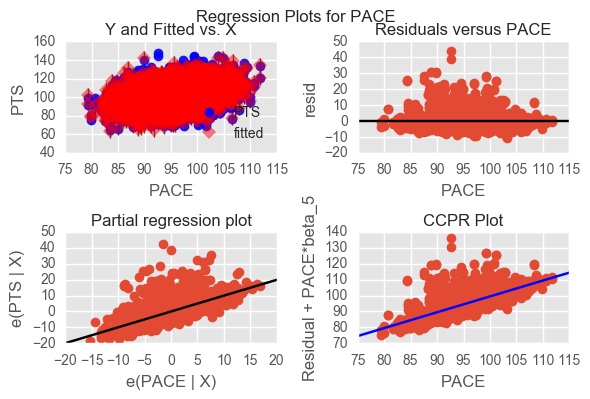

In [73]:
sm.graphics.plot_regress_exog(model, 'PACE')

pass

All residuals look to have a mean of zero -- although all also seem to have an increased variance near the mean of the given independent variable

### Train vs Test
Let's import the test data now and compare it to our training:

In [59]:
df_test = pd.read_excel('2014-2017_combined_NBA_Box_Score_Team_Stats.xlsx','2016-17')

In [69]:
def summary(X, y, model):
    _, f_pvalues = feature_selection.f_regression(X, y)

    print 'R^2 =', model.score(X, y)
    print

    print 'Coefficients'
    print '- beta_0 (Intercept) = {}'.format(model.intercept_)

    for i, coef in enumerate(model.coef_):
        print '- beta_{} ({}) = {} (p-value = {})'.format(i + 1, X.columns[i], coef, f_pvalues[i])

### Training:

In [70]:
X = df[ ['eFG_pct', 'TOV_pct', 'ORB_pct', 'FT_divby_FGA', 'PACE'] ]
y = df.PTS

model = linear_model.LinearRegression().fit(X, y)

In [71]:
model.score(X, y)

0.89277582956950319

In [72]:
summary(X, y, model)

R^2 = 0.89277582957

Coefficients
- beta_0 (Intercept) = -66.3089847804
- beta_1 (eFG_pct) = 144.068459768 (p-value = 0.0)
- beta_2 (TOV_pct) = -130.920810368 (p-value = 3.53408224955e-50)
- beta_3 (ORB_pct) = 48.6494548137 (p-value = 9.34169339482e-25)
- beta_4 (FT_divby_FGA) = 31.994048311 (p-value = 5.81471337332e-67)
- beta_5 (PACE) = 0.994642463531 (p-value = 1.50871928735e-134)


### Testing:

In [73]:
X = df_test[ ['eFG_pct', 'TOV_pct', 'ORB_pct', 'FT_divby_FGA', 'PACE'] ]
y = df_test.PTS

model = linear_model.LinearRegression().fit(X, y)

In [74]:
model.score(X, y)

0.91336219262009744

In [75]:
summary(X, y, model)

R^2 = 0.91336219262

Coefficients
- beta_0 (Intercept) = -76.5062351204
- beta_1 (eFG_pct) = 146.679924243 (p-value = 1.49515839017e-216)
- beta_2 (TOV_pct) = -134.02891556 (p-value = 1.04383886318e-13)
- beta_3 (ORB_pct) = 45.9463066638 (p-value = 3.81458752617e-06)
- beta_4 (FT_divby_FGA) = 32.7003409412 (p-value = 1.35307519133e-21)
- beta_5 (PACE) = 1.10041063562 (p-value = 3.69814745581e-43)


The R^2 and betas (both value and significance) are quite similar from train to test so I feel confident in using the coefficients from train.

### Forecasting the 'x' values for any given NBA game

Now that we have nailed down our betas (which account for ~ 90% of the variability of PTS within an NBA game, let's turn our attention to forecasting the x values for any given NBA game

A good start is NBA.com which has stats for all the required fields used in our regression and offers convenient splits on Home vs Away.  For the purposes of this analysis each team will essentially be treated as two separate teams -- their stats as a Home team and their stats as an Away team.  The relevant team data can be found here:

http://stats.nba.com/teams/four-factors/#!?sort=W_PCT&dir=-1&Season=2016-17&SeasonType=Regular%20Season&Location=Home
http://stats.nba.com/teams/four-factors/#!?sort=W_PCT&dir=-1&Season=2016-17&SeasonType=Regular%20Season&Location=Road
http://stats.nba.com/league/team/#!/advanced/?Season=2016-17&SeasonType=Regular%20Season&Location=Home
http://stats.nba.com/league/team/#!/advanced/?Season=2016-17&SeasonType=Regular%20Season&Location=Road

A fancy Data Scientist would scrape these values... but as a hack I have just copy-pasted these values.  These should be refeshed prior to any future forecast.


Each team will have offensive and defensive stats for each beta, and an average between Team A on one side of the ball and Team B on the other side of the ball should suffice.

Let's go through an example to clarify the calculation.  On 2/23, LAC (LA Clippers) will play at GSW (Golden State Warriors).  Let's forecast the score:

PTS =
-66.3089847804 + 144.068459768 * eFG_pct + -130.920810368 * TOV_pct + 48.6494548137 * ORB_pct + 31.994048311 * FT_divby_FGA + 0.994642463531 * PACE

GSW has a (home) eFG_pct of 59.5% and LAC has an (away) opponent's eFG_pct of 51.5% -- taking the average yields an expected eFG_pct of 55.4% for GSW.  This same methodology can be applied to TOV_pct, ORB_pct, FT_divby_FGA and Pace.

Crunching the math for each team yields an expected PTS for GSW of 116 and LAC of 108.

A final important step to consider is injuries.  Current injury news can be found here: http://www.rotoworld.com/teams/injuries/nba/all

It happens to be that LAC's best player, Chris Paul (who is both strong offensively and defensively), is sidelined with an injury -- so this would be a case of a non- plain vanilla game... and the Vegas odds will likely skew even more heavily towards GSW.

Let's set up a mechanism for forecasting any game between any two teams.

### Read in the data for forecasting our "x" data

In [115]:
df_Forecast = pd.read_excel('NBA_Project.xlsx','Games')

### Forecast the score of any game!

In the interest of saving time, some of the trivial lookups of looking up variables for each team in the NBA.com stats was performed within Excel.

In order to access the score forecasts, just change the home and away teams in the below, using these three letter acronyms:
    
ATL	Atlanta Hawks
BRK	Brooklyn Nets
BOS	Boston Celtics
CHO	Charlotte Hornets
CHI	Chicago Bulls
CLE	Cleveland Cavaliers
DAL	Dallas Mavericks
DEN	Denver Nuggets
DET	Detroit Pistons
GSW	Golden State Warriors
HOU	Houston Rockets
IND	Indiana Pacers
LAC	LA Clippers
LAL	Los Angeles Lakers
MEM	Memphis Grizzlies
MIA	Miami Heat
MIL	Milwaukee Bucks
MIN	Minnesota Timberwolves
NOP	New Orleans Pelicans
NYK	New York Knicks
OKC	Oklahoma City Thunder
ORL	Orlando Magic
PHI	Philadelphia 76ers
PHO	Phoenix Suns
POR	Portland Trail Blazers
SAC	Sacramento Kings
SAS	San Antonio Spurs
TOR	Toronto Raptors
UTA	Utah Jazz
WAS	Washington Wizards

Note one could even forecast a theoretical game in which a road team plays the home team version of themselves (i.e. GSW vs GSW).  This wouls give you a feeling of the magnitude of home-court advantage from team to team.

In [138]:
Away_Team = 'LAC'
Home_Team = 'GSW'

In [139]:
Away_Team_Exp_Pts = df_Forecast['Exp Pts'][df_Forecast['Tm1'] == Away_Team][df_Forecast['Tm2'] == Home_Team][df_Forecast['Home_Away'] == 'Home']
Home_Team_Exp_Pts = df_Forecast['Exp Pts'][df_Forecast['Tm1'] == Home_Team][df_Forecast['Tm2'] == Away_Team][df_Forecast['Home_Away'] == 'Away']

print "Forecasted score: %s %d, %s %d" % (Away_Team, Away_Team_Exp_Pts, Home_Team, Home_Team_Exp_Pts)

Forecasted score: LAC 108, GSW 116
